# Processamento de dados, modelagem e avaliação

Neste notebook, vou fazer o processamento de dados propostos pelos resultados encontrados na etapa de EDA, para então serem usados pelos modelos aplicados. No caso, testei três modelos de classificação diferentes para escolher a melhor performance baseada na métrica de ROC AUC. Além disso, para encontrar o melhor corte de probabilidade (threshold), usei informações da matriz de confusão e a métrica de negócio disponível: o ticket médio dos pagamentos.

Relembrando, vamos importar as seguintes informações do EDA:
- Feature 'participacao_falencia_valor' completamente zerada
- Das features categóricas, apenas "opcao_tributaria" será usada
- Das features numéricas: 
    - ['default_3months', 'ioi_36months', 'ioi_3months', 'valor_vencido','valor_quitado', 'quant_protestos', 'valor_protestos','quant_acao_judicial', 'acao_judicial_valor', 'dividas_vencidas_qtd','valor_total_pedido', 'month', 'year'] 
    - ["valor_protestos", "acao_judicial_valor", "dividas_vencidas_qtd"] tem ainda maior correlação quando aplicado o logaritmo
- Das features temporais: 
    - PCA de ['month', 'year'] aumenta ligeiramente a correlação

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix

In [2]:
# carregando dataset
data = pd.read_csv("../data/dataset_2021-5-26-10-14.csv",  sep = '\t', encoding = 'utf-8')

#### Operações sobre toda a base: descarte de colunas e aplicação de logaritmos.

In [3]:
# Descartando colunas

data.drop(columns=["participacao_falencia_valor", "atividade_principal", "forma_pagamento", "tipo_sociedade"], inplace=True)

# Aplicando log, mas cuidando com valores extremos (log(0))

def logaritmo(val):
    if val!=0:
        return np.log(val)
    else:
        return 0.0001
    
to_log_cols = ["valor_protestos", "acao_judicial_valor", "dividas_vencidas_qtd"]

for col in to_log_cols:
    data[f"log_{col}"] = data[col].apply(logaritmo)

log_cols = [f"log_{x}" for x in to_log_cols]

#### Operações aplicadas separadamente em treino e teste
Operações que passam por "fit" e "transform" são aplicadas separadamente, pois fazemos o fit no treino e aplicamos a transformação no teste - são elas normalização, PCA e Encoder

O tratamento de undersampling para balancear a base é aplicado somente no teste, já que o teste deve refletir a distribuição do problema real

In [4]:
# Separando em treino e teste

X_cols = [x for x in data.columns if x not in ["default"]]

X_train, X_test, y_train, y_test = train_test_split(data[X_cols], data["default"], train_size=0.6, test_size=0.4,random_state=0)

#### Operações no treino

In [5]:
# Criando a pipeline de transformações necessárias - treino

encoder=OneHotEncoder(handle_unknown='ignore', sparse=False)
pca = PCA(n_components=1)

# aplicando PCA nas temporais
X_train['pca_date'] = pca.fit_transform(X_train[['month', 'year']])

# encodando coluna categórica
encoded = encoder.fit_transform(np.array(X_train["opcao_tributaria"]).reshape(-1,1))
encoded_cols = [x for x in encoder.get_feature_names_out(['opcao_tributaria'])]
encoded = pd.DataFrame(encoded, columns=encoded_cols)
X_train = pd.concat([X_train
                     .drop(columns=["opcao_tributaria"])
                     .reset_index(drop=True), 
                     encoded
                    .reset_index(drop=True)], axis=1)

num_cols = ['default_3months', 'ioi_36months', 'ioi_3months', 'valor_vencido','valor_quitado', 
            'quant_protestos', 'valor_protestos','quant_acao_judicial', 'acao_judicial_valor', 
            'dividas_vencidas_qtd','valor_total_pedido']
num_cols = [x for x in num_cols if x not in to_log_cols]

In [6]:
# Undersampling

train_data = X_train.copy()
train_data["default"] = y_train.copy()


default = train_data[train_data["default"]==1]
not_default = train_data[train_data["default"]==0]

not_default_sample = resample(not_default, replace=False, n_samples=len(default), random_state=0)
train_undersampled = pd.concat([not_default_sample, default])
train_undersampled.default.describe()

count    3318.000000
mean        0.500000
std         0.500075
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: default, dtype: float64

Agora temos uma amostra de treino com metade do target sendo default e a outra metade não, uma amostra balanceada

#### Operações no teste

In [7]:
# Aplicando pipeline de transformações necessárias - teste

# aplicando PCA nas temporais
X_test['pca_date'] = pca.transform(X_test[['month', 'year']])

# encodando coluna categórica
encoded = encoder.transform(np.array(X_test["opcao_tributaria"]).reshape(-1,1))
encoded = pd.DataFrame(encoded, columns=encoded_cols)
X_test = pd.concat([X_test
                     .drop(columns=["opcao_tributaria"])
                     .reset_index(drop=True), 
                     encoded
                    .reset_index(drop=True)], axis=1)


In [8]:
X_train.columns

Index(['default_3months', 'ioi_36months', 'ioi_3months', 'valor_por_vencer',
       'valor_vencido', 'valor_quitado', 'quant_protestos', 'valor_protestos',
       'quant_acao_judicial', 'acao_judicial_valor', 'dividas_vencidas_valor',
       'dividas_vencidas_qtd', 'falencia_concordata_qtd', 'valor_total_pedido',
       'month', 'year', 'log_valor_protestos', 'log_acao_judicial_valor',
       'log_dividas_vencidas_qtd', 'pca_date', 'opcao_tributaria_isento',
       'opcao_tributaria_lucro presumido', 'opcao_tributaria_lucro real',
       'opcao_tributaria_missing', 'opcao_tributaria_simples nacional'],
      dtype='object')

## Modelagem
A seguir faremos diretamente treino e teste com três modelos diferentes e em seguida avaliaremos os resultados sobre o teste

In [9]:
def train_models(selected_cols, X_train, y_train):
    
    # Logistic regression
    logreg_model = LogisticRegression()
    logreg_model.fit(X_train[selected_cols], y_train)
    y_pred_logreg=logreg_model.predict_proba(X_test[selected_cols])

    # Light GBM
    lgb_model = lgb.LGBMClassifier()
    lgb_model.fit(X_train[selected_cols], y_train)
    y_pred_lgb=lgb_model.predict_proba(X_test[selected_cols])

    # XGBoost
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train[selected_cols], y_train)
    y_pred_xgb = xgb_model.predict_proba(X_test[selected_cols])
    
    
    models=[logreg_model, lgb_model, xgb_model]
    model_names=["Logistic regression", "LGBM", "XGBoost"]
    predictions = [y_pred_logreg[:,1],y_pred_lgb[:,1],y_pred_xgb[:,1]]
    
    return (models, model_names, predictions)

In [10]:
def plot_roc_auc(model_names, predictions):
    
    plt.figure(figsize=(10,8))

    for model_name, y_proba in zip(model_names, predictions):

        fpr, tpr, thr = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        f1 = f1_score(y_test, [0 if x<0.5 else 1 for x in y_proba])
        label = model_name+"\nAUC={:.4f}\nF1={:.4}".format(roc_auc, f1)
        plt.plot(fpr,tpr, label=label)


    plt.plot([0,1],[0,1], '--', color='gray', label='Random Classifier')
    plt.plot([0, 0, 1], [0, 1, 1],'--', color='black', label="Perfect Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.title("ROC Curve")

## SEM Undersampling

#### Considerando numéricas SEM log, mês e ano e colunas encodadas

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11757, number of negative: 58606
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1675
[LightGBM] [Info] Number of data points in the train set: 70363, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167091 -> initscore=-1.606388
[LightGBM] [Info] Start training from score -1.606388


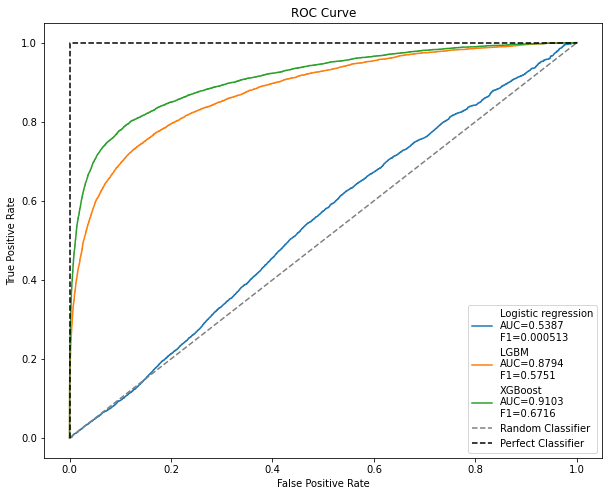

In [11]:
selected_cols = to_log_cols+["month","year"]+num_cols+encoded_cols

# treino dos modelos
(models, model_names, predictions) = train_models(selected_cols,X_train, y_train)
# plotando resultados
plot_roc_auc(model_names, predictions)

#### Considerando numéricas COM log, mês e ano e colunas encodadas

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11757, number of negative: 58606
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1673
[LightGBM] [Info] Number of data points in the train set: 70363, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167091 -> initscore=-1.606388
[LightGBM] [Info] Start training from score -1.606388


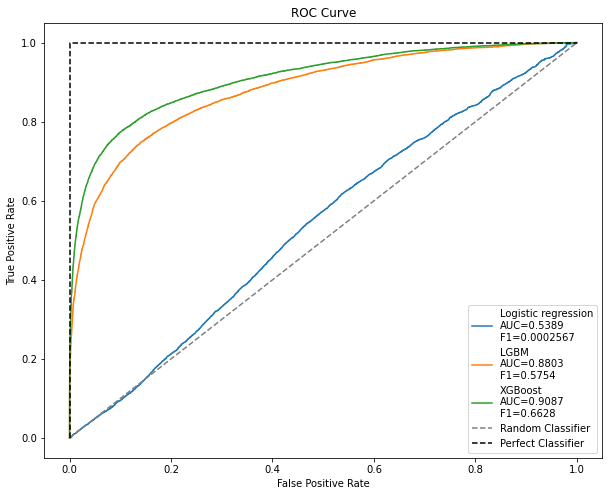

In [12]:
selected_cols = log_cols+["month","year"]+num_cols+encoded_cols

# treino dos modelos
(models, model_names, predictions) = train_models(selected_cols,X_train, y_train)
# plotando resultados
plot_roc_auc(model_names, predictions)

#### Considerando numéricas SEM log, pca_date e colunas encodadas

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11757, number of negative: 58606
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1693
[LightGBM] [Info] Number of data points in the train set: 70363, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167091 -> initscore=-1.606388
[LightGBM] [Info] Start training from score -1.606388


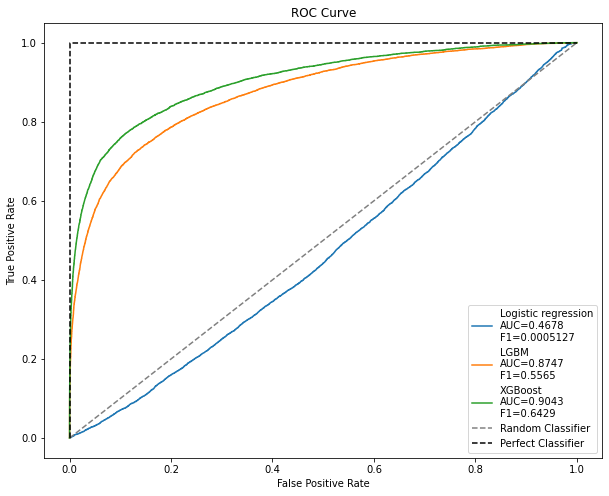

In [13]:
selected_cols = log_cols+["pca_date"]+num_cols+encoded_cols

# treino dos modelos
(models, model_names, predictions) = train_models(selected_cols,X_train, y_train)
# plotando resultados
plot_roc_auc(model_names, predictions)

No fim, apesar da coluna de data criada com PCA ter um pouco mais de correlação com a variável final, não foi melhor que os dados de mês e ano na performance do modelo. 

## COM Undersampling

#### Considerando numéricas SEM log, mês e ano e colunas encodadas

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1659, number of negative: 1659
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1232
[LightGBM] [Info] Number of data points in the train set: 3318, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


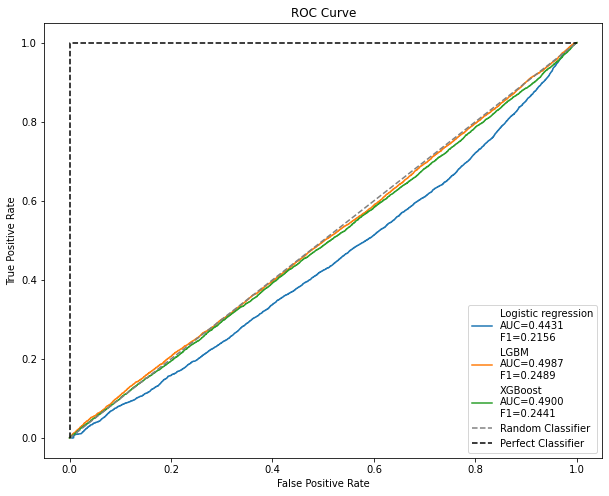

In [14]:
selected_cols = to_log_cols+["month","year"]+num_cols+encoded_cols

# treino dos modelos
(models, model_names, predictions) = train_models(selected_cols,train_undersampled.copy(), train_undersampled["default"].copy())
# plotando resultados
plot_roc_auc(model_names, predictions)

Observamos que neste caso o undersampling não ajudou na performance do modelo. Essa operação pode ser mais útil para casos em que a base é altamente desbalanceada e o modelo pode acabar prevendo sempre classe negativa e ainda assim acertando. Por isso olhamos para mais de uma métrica nesse caso: ROC AUC e F1 score.

Percebemos justamente que a métrica de F1 da regressão logística, um modelo mais sensível ao desbalanceamento, melhora em relação aos casos anteriores com o dataset balanceado. Porém, a ROC AUC é um benchmark melhor no sentido de ser mais geral por representar se a probabilidade de prever um default corretamente é maior do que a probabilidade de prever um default como não-default.

### Salvando o modelo no melhor caso
Considerando numéricas SEM log, mês e ano e colunas encodadas, salvando no formato pickle

In [15]:
# Treinando o modelo no melhor caso
selected_cols = to_log_cols+["month","year"]+num_cols+encoded_cols
model = XGBClassifier()
model.fit(X_train[selected_cols], y_train)

# Salvando
model_pkl_file = "../models/default_xgboost_classifier.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)
    
# Guardando sua predição
y_proba = model.predict_proba(X_test[selected_cols])[:,1]

#### Selecionando o melhor threshold

Vamos olhar também para a matriz de confusão para entender onde estamos errando e como a mudança no corte da classificação afeta esse resultado, usando agora nosso modelo elegido como melhor ROC AUC: o XGBoost

Na teoria, um ponto ótimo de corte seria onde o F1 score é máximo

In [16]:
# Podemos obter os valores ao longo do corte a partir da curva PR
precision, recall, threshold = precision_recall_curve(y_test, y_proba)
fscore = (2 * precision * recall) / (precision + recall)

idx = np.argmax(fscore)

best_thr = round(threshold[idx], ndigits=4)
best_f1 = round(fscore[idx], ndigits=4)
best_prec = round(precision[idx], ndigits=4)
best_recall = round(recall[idx], ndigits=4)

print('Melhor valor de corte: {:.4} com F1 score igual a {:.4}'.format(best_thr, fscore[idx]))

Melhor valor de corte: 0.2976 com F1 score igual a 0.722


In [17]:
print("Tamanho da amostra de teste: ", y_test.shape[0])

Tamanho da amostra de teste:  46910


#### Avaliando as matrizes de confusão para o corte padrão (0.5) e o ótimo teórico (0.29)

As matrizes podem ser interpretadas da seguinte forma:

Para o valor de corte igual a 0.5000
54.49% dos defaults que ocorreram seriam detectados por esse modelo        
1.55% dos não-defaults seriam apontados como default
Valor recebido nesse caso: R$899693147
Valor perdido nesse caso R$-64901329

Para o valor de corte igual a 0.2976
69.43% dos defaults que ocorreram seriam detectados por esse modelo        
4.56% dos não-defaults seriam apontados como default
Valor recebido nesse caso: R$892138841
Valor perdido nesse caso R$-57347023



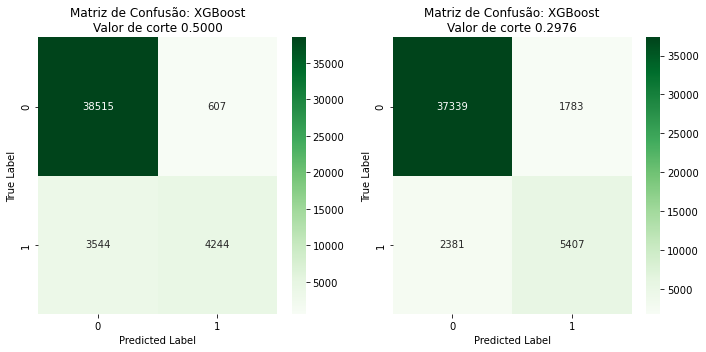

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

thresholds_list = [0.5, best_thr]

ticket_medio_default = -18882
ticket_medio_pago = 25097

print('As matrizes podem ser interpretadas da seguinte forma:\n')

for thr,ax in zip(thresholds_list, axs.ravel()):

    y_pred = [0 if x < thr else 1 for x in y_proba]

    cf_mtx = confusion_matrix(y_test,y_pred)

    tn, fp, fn, tp = cf_mtx.ravel()
    print("Para o valor de corte igual a {:.4f}".format(thr))
    print( '{:.2f}% dos defaults que ocorreram seriam detectados por esse modelo\
        \n{:.2f}% dos não-defaults seriam apontados como default'\
        .format(tp/(tp+fn)*100, fp/(fp+tn)*100) )
    gain = ticket_medio_default*fn + ticket_medio_pago*tn
    lost = ticket_medio_default*tp + ticket_medio_pago*fp
    print(f"Valor recebido nesse caso: R${gain}\nValor perdido nesse caso R${lost}\n")

    cf_mtx = sns.heatmap(cf_mtx, cmap="Greens", annot = True, fmt='g', ax=ax)
    cf_mtx.set(xlabel="Predicted Label", ylabel ="True Label", title="Matriz de Confusão: XGBoost\nValor de corte {:.4f}".format(thr))

fig.tight_layout()
plt.show()

Como o problema da empresa X-Health é reduzir o número de defaults, queremos reduzir o número de falsos negativos. Portanto, um valor de corte de 0.29 de fato aumenta a detecção de defaults.

Porém, ir nessa direção necessariamente implica em aumentar o número de falsos positivos e, para tomar a decisão de o quanto vale abrir mão de um cliente para evitar o risco de default, é necessário levar em conta informações sobre os valores de cada uma dessas operações.

Text(0, 0.5, 'Ganho')

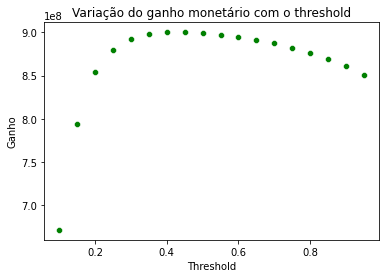

In [19]:
# Avaliando ganhos em dinheiro para diferentes cortes

thresholds_list = np.arange(0.1,1,0.05)
gains =[]
losts =[]

ticket_medio_default = -18882
ticket_medio_pago = 25097

for thr in thresholds_list:

    y_pred = [0 if x < thr else 1 for x in y_proba]

    cf_mtx = confusion_matrix(y_test,y_pred)

    tn, fp, fn, tp = cf_mtx.ravel()

    gain = ticket_medio_default*fn + ticket_medio_pago*tn
    lost = ticket_medio_default*tp + ticket_medio_pago*fp
    gains.append(gain)
    losts.append(lost)

sns.scatterplot(x=thresholds_list, y=gains, color='green')
plt.title("Variação do ganho monetário com o threshold")
plt.xlabel("Threshold")
plt.ylabel("Ganho")

Text(0, 0.5, 'Ganho')

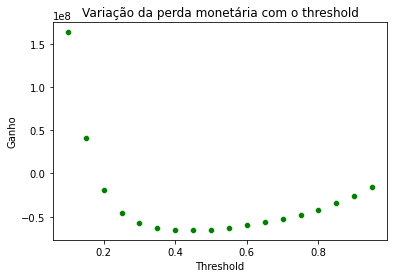

In [20]:
sns.scatterplot(x=thresholds_list, y=losts, color='green')
plt.title("Variação da perda monetária com o threshold")
plt.xlabel("Threshold")
plt.ylabel("Ganho")

In [21]:
idx_max_gain = np.argmax(gains)
idx_min_losts = np.argmin(losts)
print(f"Threshold com máximo ganho de R${gains[idx_max_gain]}: {thresholds_list[idx_max_gain]}")
print(f"Threshold com mínimo de perda de R${losts[idx_min_losts]}: {thresholds_list[idx_min_losts]}")

Threshold com máximo ganho de R$900047954: 0.45000000000000007
Threshold com mínimo de perda de R$-65256136: 0.45000000000000007


Para o valor de corte igual a 0.45
57.96% dos defaults que ocorreram seriam detectados por esse modelo    
2.03% dos não-defaults seriam apontados como default


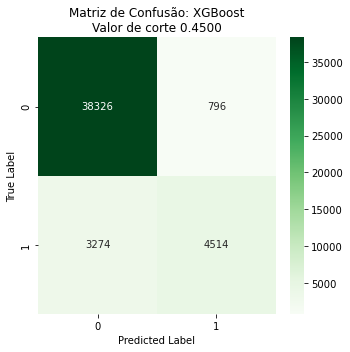

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

thr = 0.45

y_pred = [0 if x < thr else 1 for x in y_proba]

cf_mtx = confusion_matrix(y_test,y_pred)

tn, fp, fn, tp = cf_mtx.ravel()
print("Para o valor de corte igual a {:.2f}".format(thr))
print( '{:.2f}% dos defaults que ocorreram seriam detectados por esse modelo\
    \n{:.2f}% dos não-defaults seriam apontados como default'\
    .format(tp/(tp+fn)*100, fp/(fp+tn)*100) )

cf_mtx = sns.heatmap(cf_mtx, cmap="Greens", annot = True, fmt='g', ax=ax)
cf_mtx.set(xlabel="Predicted Label", ylabel ="True Label", title="Matriz de Confusão: XGBoost\nValor de corte {:.4f}".format(thr))

fig.tight_layout()
plt.show()

# Conclusão
- Apesar da base ser desbalanceada, o tratamento de undersampling não se mostrou necessário
- O melhor modelo para essas condições foi o XGBoost usando um threshold de 0.45 - encontrado a partir de regras de negócio que se aplicam melhor que uma otimização mais generalista
- Muitos dos tratamentos propostos não tiveram impactos positivos no modelo.
- Uma possível melhora seria investigar os parâmetros do modelo

## Observação

Retirei um teste do notebook para não ficar muito poluído, relativo à normalização dos dados numéricos
- Testar normalizar os dados numéricos, pois a função de modelos paramétricos podem se beneficiar dessa operação, como foi o caso da regressão logística, que estava cerca de 0.01 ponto de ROC AUC melhor COM normalização. Já os modelos baseados em árvore são negativamente afetados, pois isso reduz a variância das features e, portanto, a variância da informação que carregam. A ROC AUC com normalização dos dados estava em cerca de 0.6 e 0.7 para o XGBoost e LGBM
